# Классификация произведений писателей

In [82]:
import numpy as np # Для работы с данными 
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
from config import Config
%matplotlib inline

from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Flatten, Activation, Embedding # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последователь

In [83]:
# Загрузка данных файлов в списки 
trainWordIndexes = np.load(Config.TRAIN_WORD_INDEXES_FILENAME, allow_pickle=True)
testWordIndexes = np.load(Config.TEST_WORD_INDEXES_FILENAME, allow_pickle=True)

labels = ["Достоевский", "Стругацкие"] # Наши авторы
labelsNum = len(labels)

Создаем xTrain и yTrain

In [84]:
# Формирование обучающей выборки по листу индексов слов
# путем разделения на короткие векторы
# wordIndexes - массив индексов
# xLen - размер окна
# step - шаг окна
def getSetFromIndexes(wordIndexes, xLen, step):
  xText = []
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen): # Идём по всей длине вектора индексов
    xText.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xText


# Формирование обучающей и проверочной выборки для каждого класса
# wordIndexes - массив индексов
# xLen - размер окна
# step - шаг окна
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна
  nClasses = len(wordIndexes) # Количество классов
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step))

  # Формируем один общий xSamples
  xSamples = []
  ySamples = []
  
  for t in range(nClasses):
    xT = classesXSamples[t]
    for i in range(len(xT)): # Перебираем каждое окно определенного класса
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples)
  ySamples = np.array(ySamples)

  
  return (xSamples, ySamples)

In [85]:
# Задаём базовые параметры
xLen = 500 # Размер окна (количество слов в векторе)
step = 60 # Шаг разбиения текста на векторы
numWords = 20000

In [86]:
# Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, xLen)
print("Размерности тренировочного набора")
print(xTrain.shape)
print(yTrain.shape)
print()
print("Размерности тестового набора")
print(xTest.shape)
print(yTest.shape)

Размерности тренировочного набора
(6721, 500)
(6721, 2)

Размерности тестового набора
(86, 500)
(86, 2)


In [87]:
print(xTrain[0])

[ 5748    69   652    16  8497  1554   223   249   381  3499     3  6461
    30   124   255   303   336 16379     2   313   233  2400  1258   120
    29   391    14     1    45 12534  4694     2  1324  8498    27  3733
   846   298 16380 12535 16381   820    85   194   164  5168     2 16382
  7346    66  2500     1   405 10161     3     2   232     1    27     1
  5749 16383     1   280  1713   187  2911    44  1605     7    49  3084
    27     2 16384 16385   298    62    23   129     1    51  1291     1
  6461    22   406  8499  2615    29  1853     5    86   614  4015     4
   124 10162    45  2291     4  1782    19  1478    27   138    21  2093
  1186  5169   626   588   774  1854     1  8500     3   240 10163  3085
  3499   250   271    29   156     5   774   501  6462  8501  6463  1029
     2  5170    16   697   239    21  4695     3    13     6   447   711
    29    19    34   517     2    91   293 10164  6464     9  1187 16386
     3  1119  1783    45    19    34  1855    42  3

In [88]:
print("Размерность обучайющей выборки")
print(xTrain.shape)
print(yTrain.shape)

print()

print("Размерность тестовой выборки")
print(xTest.shape)
print(yTest.shape)


Размерность обучайющей выборки
(6721, 500)
(6721, 2)

Размерность тестовой выборки
(86, 500)
(86, 2)


Нейросеть для классификации текстов на базе Embedding

In [89]:
# Создаём полносвязную сеть
model = Sequential()
model.add(Embedding(numWords, 10, input_length=xLen))
model.add(SpatialDropout1D(0.20))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 500, 10)           200000    
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 500, 10)          0         
 lDropout1D)                                                     
                                                                 
 flatten_7 (Flatten)         (None, 5000)              0         
                                                                 
 batch_normalization_7 (Batc  (None, 5000)             20000     
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 2)                 10002     
                                                                 
Total params: 230,002
Trainable params: 220,002
Non-tr

In [79]:
# Обучаем сеть
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=64,
                    validation_split=0.2)

Epoch 1/20
84/84 [==============================] - 2s 13ms/step - loss: 0.1568 - accuracy: 0.9355 - val_loss: 4.2961 - val_accuracy: 0.2914
Epoch 2/20
84/84 [==============================] - 1s 12ms/step - loss: 0.0055 - accuracy: 0.9994 - val_loss: 5.3114 - val_accuracy: 0.2914
Epoch 3/20
84/84 [==============================] - 1s 12ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 5.7586 - val_accuracy: 0.2914
Epoch 4/20
84/84 [==============================] - 1s 11ms/step - loss: 7.1966e-04 - accuracy: 1.0000 - val_loss: 6.0858 - val_accuracy: 0.2914
Epoch 5/20
84/84 [==============================] - 2s 22ms/step - loss: 4.4400e-04 - accuracy: 1.0000 - val_loss: 6.3326 - val_accuracy: 0.2914
Epoch 6/20
84/84 [==============================] - 2s 26ms/step - loss: 3.2234e-04 - accuracy: 1.0000 - val_loss: 6.5445 - val_accuracy: 0.2914
Epoch 7/20
84/84 [==============================] - 2s 22ms/step - loss: 2.4477e-04 - accuracy: 1.0000 - val_loss: 6.7300 - val_accuracy: 0.29

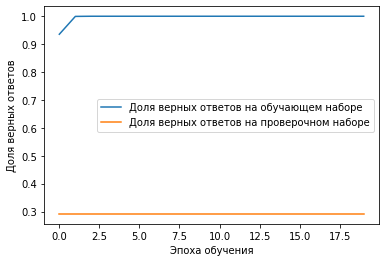

In [80]:
# Результаты обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Проверяем работу обученной нейросети

In [81]:
# Проверяем точность на тестовой выборке

rightAnswer = [0,0,0,0,0,0]
totalAnswer = [0,0,0,0,0,0]

# Получаем результаты распознавания для каждого класса
currPred = model.predict(xTest)
# Определяем номер распознанного класса для каждохо вектора
currOut = np.argmax(currPred, axis=1)
# Определяем правильный класс для каждохо вектора
yOut = np.argmax(yTest, axis=1)

print(currPred.shape)
print(currOut.shape)
print(yOut.shape)
print()


# Считаем сколько ответов всего и сколько из них правильных
for i in range(len(yOut)):
  predictA = currOut[i]
  rightA   = yOut[i]

  totalAnswer[rightA] += 1
  if predictA == rightA:
    rightAnswer[rightA] += 1

# Подсчитываем точность классификации
print("Точность распознавания текстов писателей")
for i in range(labelsNum):
  RTAnswer = 0 if rightAnswer[i] == 0 else (rightAnswer[i]/totalAnswer[i]*100)
  print("{:12s}: {:3d} из {:3d} - {:3.2f}%".format(labels[i], rightAnswer[i], totalAnswer[i], RTAnswer))

(86, 2)
(86,)
(86,)

Точность распознавания текстов писателей
Достоевский :  20 из  20 - 100.00%
Стругацкие  :   0 из  66 - 0.00%
